# Vision Transformers


## Import Keras dataset and required libraries


In [1]:
import warnings
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import tensorflow_addons as tfa
from tensorflow import keras
from tensorflow.keras import layers

# suppressing warning messages
warnings.filterwarnings('ignore')

C:\Python311\Lib\site-packages\tensorflow_addons\utils\tfa_eol_msg.py:23: UserWarning: 

TensorFlow Addons (TFA) has ended development and introduction of new features.
TFA has entered a minimal maintenance and release mode until a planned end of life in May 2024.
Please modify downstream libraries to take dependencies from other repositories in our TensorFlow community (e.g. Keras, Keras-CV, and Keras-NLP). 

For more information see: https://github.com/tensorflow/addons/issues/2807 

  warnings.warn(


### Load CIFAR-10 Dataset and split it into training and testing


In [2]:
num_classes = 10
input_shape = (32, 32, 3)

(x_train, y_train), (x_test, y_test) = keras.datasets.cifar10.load_data()

print(f"x_train shape: {x_train.shape}, y_train shape: {y_train.shape}")
print(f"x_test shape: {x_test.shape}, y_test shape: {y_test.shape}")

x_train shape: (50000, 32, 32, 3), y_train shape: (50000, 1)
x_test shape: (10000, 32, 32, 3), y_test shape: (10000, 1)


In [3]:
# selecting first 4k samples out of 50k for training
x_train = x_train[:4000]
y_train = y_train[:4000]
# selecting first 2k samples out of 10k for testing
x_test = x_test[:2000]
y_test = y_test[:2000]

## Hyper Parameter Definition


In [4]:
learning_rate = 0.001
weight_decay = 0.0001
batch_size = 256
num_epochs = 40
image_size = 72
patch_size = 6
num_patches = (image_size // patch_size) ** 2
num_heads = 4
projection_dim = 64
transformer_units = [projection_dim * 2, projection_dim]
transformer_layers = 8
mlp_head_units = [2048, 1024]

## Building ViT classifier


### Data augmentation


In [5]:
data_augmentation = keras.Sequential(
    [
        layers.Normalization(),
        layers.Resizing(image_size, image_size),
        layers.RandomFlip('horizontal'),
        layers.RandomRotation(factor = 0.02),
        layers.RandomZoom(height_factor = 0.2, width_factor = 0.2)
    ],
    name = 'data_augmentation',
)
data_augmentation.layers[0].adapt(x_train)

### Define MLP architecture


In [13]:
def mlp(x, hidden_units, dropout_rate):
    for units in hidden_units:
        x = layers.Dense(units, activation = tf.nn.gelu)(x)
        x = layers.Dropout(dropout_rate)(x)
    return x

### Patches


In [14]:
class Patches(layers.Layer):
    def __init__(self, patch_size):
        super(Patches, self).__init__()
        self.patch_size = patch_size

    def call(self, images):
        batch_size = tf.shape(images)[0]
        patches = tf.image.extract_patches(
            images = images,
            sizes = [1, self.patch_size, self.patch_size, 1],
            strides = [1, self.patch_size, self.patch_size, 1],
            rates = [1, 1, 1, 1],
            padding = 'VALID',
        )
        patch_dims = patches.shape[-1]
        patches = tf.reshape(patches, [batch_size, -1, patch_dims])
        return patches

Image size: 72 X 72
Patch size: 6 X 6
Patches per image: 144
Elements per image: 108


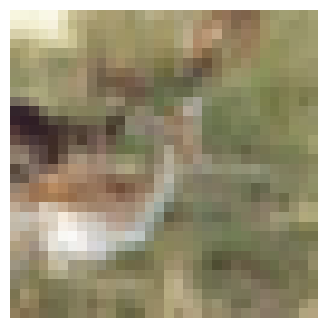

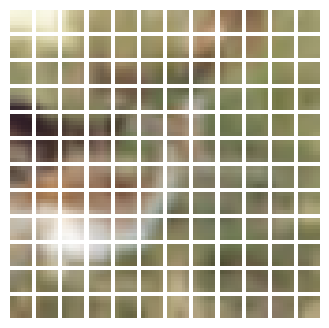

In [15]:
plt.figure(figsize = (4, 4))
image = x_train[np.random.choice(range(x_train.shape[0]))]
plt.imshow(image.astype('uint8'))
plt.axis('off')

resized_image = tf.image.resize(
    tf.convert_to_tensor([image]), size = (image_size, image_size)
)

patches = Patches(patch_size)(resized_image)
print(f"Image size: {image_size} X {image_size}")
print(f"Patch size: {patch_size} X {patch_size}")
print(f"Patches per image: {patches.shape[1]}")
print(f"Elements per image: {patches.shape[-1]}")

n = int(np.sqrt(patches.shape[1]))
plt.figure(figsize = (4, 4))
for i, patch in enumerate(patches[0]):
    ax = plt.subplot(n, n, i+1)
    patch_image = tf.reshape(patch, (patch_size, patch_size, 3))
    plt.imshow(patch_image.numpy().astype('uint8'))
    plt.axis('off')


In [16]:
class Encoder(layers.Layer):
    def __init__(self, num_patches, projection_dim):
        super(Encoder, self).__init__()
        self.num_patches = num_patches
        self.projection = layers.Dense(units = projection_dim)
        self.position_embedding = layers.Embedding(
            input_dim = num_patches,
            output_dim = projection_dim
        )

    def call(self, patch):
        positions = tf.range(start = 0, limit = self.num_patches, delta = 1)
        encoded = self.projection(patch) + self.position_embedding(positions)
        return encoded

In [17]:
def create_vit_classifier():
    inputs = layers.Input(shape = input_shape)
    augmented = data_augmentation(inputs)
    patches = Patches(patch_size)(augmented)
    encoded_patches = Encoder(num_patches, projection_dim)(patches)

    for _ in range(transformer_layers):
        x1 = layers.LayerNormalization(epsilon = 1e-6)(encoded_patches)
        attention_output = layers.MultiHeadAttention(
            num_heads = num_heads,
            key_dim = projection_dim,
            dropout = 0.1
        )(x1, x1)

        x2 = layers.Add()([attention_output, encoded_patches])

        x3 = layers.LayerNormalization(epsilon = 1e-6)(x2)
        x3 = mlp(x3, hidden_units = transformer_units, dropout_rate = 0.1)

        encoded_patches = layers.Add()([x3, x2])

    representation = layers.LayerNormalization(epsilon = 1e-6)(encoded_patches)
    representation = layers.Flatten()(representation)
    representation = layers.Dropout(0.5)(representation)

    features = mlp(representation, hidden_units = mlp_head_units, dropout_rate = 0.5)
    logits = layers.Dense(num_classes)(features)

    model = keras.Model(inputs = inputs, outputs = logits)
    return model

In [18]:
def run(model):
    optimizer = tfa.optimizers.AdamW(
        learning_rate = learning_rate,
        weight_decay = weight_decay
    )
    
    model.compile(
        optimizer = optimizer,
        loss = keras.losses.SparseCategoricalCrossentropy(from_logits = True),
        metrics = [
            keras.metrics.SparseCategoricalAccuracy(name='accuracy'),
            keras.metrics.SparseTopKCategoricalAccuracy(5, name='top-5-accuracy'),
        ],
    )

    checkpoint_filepath = './tmp/checkpoint'
    checkpoint_callback = keras.callbacks.ModelCheckpoint(
        checkpoint_filepath,
        monitor='val_accuracy',
        save_best_only=True,
        save_weights_only=True
    )

    history = model.fit(
        x=x_train,
        y=y_train,
        batch_size=batch_size,
        epochs=num_epochs,
        validation_split=0.1,
        callbacks=[checkpoint_callback],
    )

    model.load_weights(checkpoint_filepath)
    _, accuracy, top_5_accuracy = model.evaluate(x_test, y_test)
    print(f"Test accuracy: {round(accuracy * 100, 2)}%")
    print(f"Test Top 5 accuracy: {round(top_5_accuracy * 100, 2)}%")

    return history

In [19]:
vit_classifier = create_vit_classifier()
history = run(vit_classifier)

Epoch 1/40
15/15 [==============================] - 262s 15s/step - loss: 4.2119 - accuracy: 0.1608 - top-5-accuracy: 0.6178 - val_loss: 2.0386 - val_accuracy: 0.2400 - val_top-5-accuracy: 0.7625
Epoch 2/40
15/15 [==============================] - 232s 16s/step - loss: 2.3373 - accuracy: 0.2122 - top-5-accuracy: 0.7022 - val_loss: 1.9935 - val_accuracy: 0.3125 - val_top-5-accuracy: 0.7800
Epoch 3/40
15/15 [==============================] - 207s 14s/step - loss: 2.1711 - accuracy: 0.2350 - top-5-accuracy: 0.7494 - val_loss: 1.9345 - val_accuracy: 0.2925 - val_top-5-accuracy: 0.8100
Epoch 4/40
15/15 [==============================] - 193s 13s/step - loss: 2.0695 - accuracy: 0.2639 - top-5-accuracy: 0.7819 - val_loss: 1.9655 - val_accuracy: 0.2825 - val_top-5-accuracy: 0.7875
Epoch 5/40
15/15 [==============================] - 215s 14s/step - loss: 2.0225 - accuracy: 0.2675 - top-5-accuracy: 0.7933 - val_loss: 1.8602 - val_accuracy: 0.3400 - val_top-5-accuracy: 0.8300
Epoch 6/40
15/15 [==

In [20]:
class_names = [
    'airplane',
    'automobile',
    'bird',
    'cat',
    'deer',
    'dog',
    'frog',
    'horse',
    'ship',
    'truck'
]

In [21]:
def img_predict(images, model):
    if len(images.shape) == 3:
        out = model.predict(images.reshape(-1, *images.shape))
    else:
        out = model.predict(images)
    prediction = np.argmax(out, axis=1)
    img_prediction = [class_names[i] for i in prediction]
    return img_prediction

## Tests


1/1 [==============================] - 0s 48ms/step
['truck']


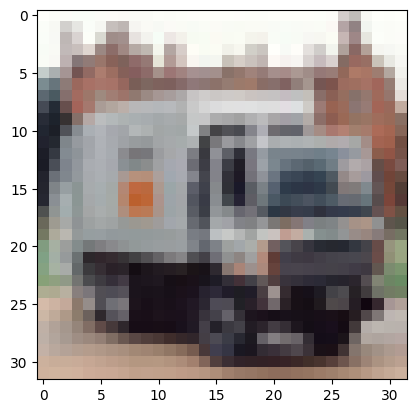

In [26]:
index = 11
plt.imshow(x_test[index])
prediction = img_predict(x_test[index], vit_classifier)
print(prediction)

1/1 [==============================] - 0s 50ms/step
['frog']


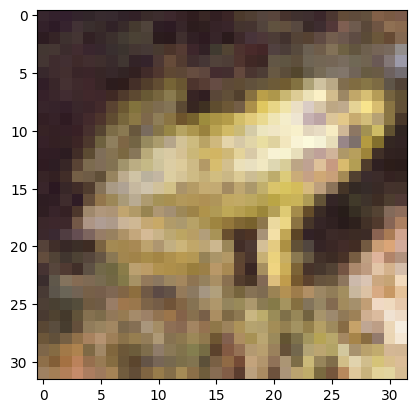

In [29]:
index = 19
plt.imshow(x_test[index])
prediction = img_predict(x_test[index], vit_classifier)
print(prediction)